In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, f1_score,
    classification_report, confusion_matrix
)

RANDOM_STATE = 42

# === Chargement des features sélectionnées ===
X = pd.read_csv("data/X_selections.csv")
y = pd.read_csv("data/y.csv").squeeze().astype(int)
y.name = "target"

print(f"Shape X: {X.shape} | Shape y: {y.shape}")
print("Distribution de la cible:\n", y.value_counts(normalize=True).round(3))

# Split stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)
print("Train:", X_train.shape, "| Test:", X_test.shape)


Shape X: (98053, 25) | Shape y: (98053,)
Distribution de la cible:
 target
0    0.887
1    0.113
Name: proportion, dtype: float64
Train: (68637, 25) | Test: (29416, 25)


In [5]:
scaler = StandardScaler()

mlp_small = Pipeline([
    ("scaler", scaler),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64,),
        activation="relu",
        alpha=1e-4,
        batch_size=512,
        learning_rate_init=1e-3,
        max_iter=100,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])

mlp_medium = Pipeline([
    ("scaler", scaler),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=1e-4,
        batch_size=512,
        learning_rate_init=1e-3,
        max_iter=100,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])

mlp_large = Pipeline([
    ("scaler", scaler),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        alpha=1e-4,
        batch_size=512,
        learning_rate_init=1e-3,
        max_iter=120,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}

def cv_scores(pipe, name):
    scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{name:>12} | PR-AUC: {scores['test_pr_auc'].mean():.3f} ± {scores['test_pr_auc'].std():.3f} "
          f"| ROC-AUC: {scores['test_roc_auc'].mean():.3f} ± {scores['test_roc_auc'].std():.3f}")
    return scores

scores_small  = cv_scores(mlp_small,  "MLP small")
scores_medium = cv_scores(mlp_medium, "MLP medium")
scores_large  = cv_scores(mlp_large,  "MLP large")


   MLP small | PR-AUC: 0.200 ± 0.007 | ROC-AUC: 0.639 ± 0.008
  MLP medium | PR-AUC: 0.198 ± 0.007 | ROC-AUC: 0.640 ± 0.009
   MLP large | PR-AUC: 0.201 ± 0.008 | ROC-AUC: 0.641 ± 0.006


In [7]:
mean_pr = {
    "small":  scores_small["test_pr_auc"].mean(),
    "medium": scores_medium["test_pr_auc"].mean(),
    "large":  scores_large["test_pr_auc"].mean()
}
best_name = max(mean_pr, key=mean_pr.get)
print("\n=> Meilleur MLP (PR-AUC CV) :", best_name)

if best_name == "small":
    best_mlp = mlp_small
elif best_name == "medium":
    best_mlp = mlp_medium
else:
    best_mlp = mlp_large



=> Meilleur MLP (PR-AUC CV) : large


In [8]:
# Entraînement sur tout le train
best_mlp.fit(X_train, y_train)

# Probabilités sur test
proba_test = best_mlp.predict_proba(X_test)[:, 1]

print(f"Test PR-AUC  : {average_precision_score(y_test, proba_test):.3f}")
print(f"Test ROC-AUC : {roc_auc_score(y_test, proba_test):.3f}")


Test PR-AUC  : 0.189
Test ROC-AUC : 0.627


In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, proba_test)
f1 = 2 * precision * recall / (precision + recall + 1e-12)
idx = np.nanargmax(f1)
thr = thresholds[idx-1] if 0 < idx < len(thresholds) else 0.5

y_pred = (proba_test >= thr).astype(int)

print(f"Seuil choisi (max F1) : {thr:.3f} | F1 = {f1[idx]:.3f}\n")
print("Classification report (MLP):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)


Seuil choisi (max F1) : 0.128 | F1 = 0.254

Classification report (MLP):
              precision    recall  f1-score   support

           0      0.912     0.742     0.819     26096
           1      0.179     0.440     0.254      3320

    accuracy                          0.708     29416
   macro avg      0.546     0.591     0.536     29416
weighted avg      0.830     0.708     0.755     29416

Confusion matrix:
 [[19372  6724]
 [ 1858  1462]]


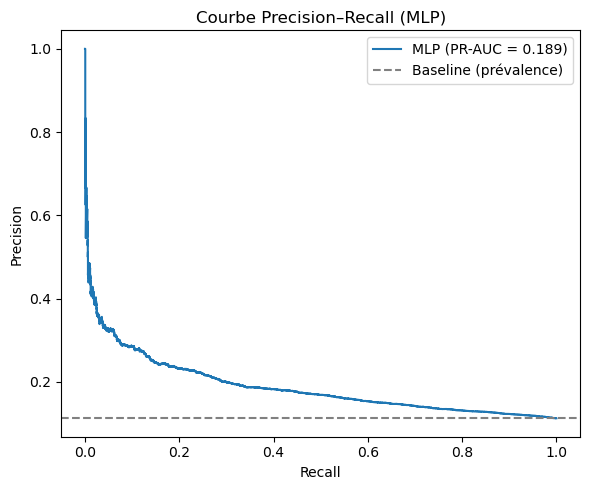

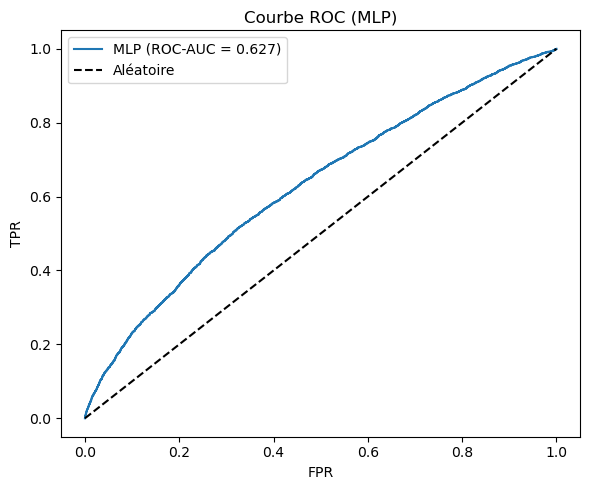

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Courbe PR
precision, recall, _ = precision_recall_curve(y_test, proba_test)
pr_auc = average_precision_score(y_test, proba_test)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"MLP (PR-AUC = {pr_auc:.3f})")
plt.axhline(y=y_test.mean(), ls="--", color="grey", label="Baseline (prévalence)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision–Recall (MLP)")
plt.legend()
plt.tight_layout()
plt.show()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, proba_test)
roc_auc = roc_auc_score(y_test, proba_test)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"MLP (ROC-AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--", label="Aléatoire")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbe ROC (MLP)")
plt.legend()
plt.tight_layout()
plt.show()


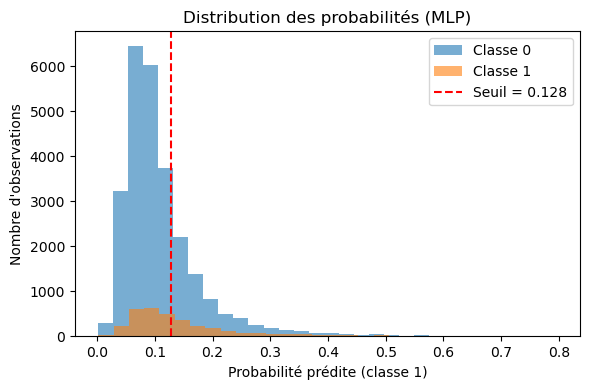

In [11]:
plt.figure(figsize=(6,4))
plt.hist(proba_test[y_test==0], bins=30, alpha=0.6, label="Classe 0")
plt.hist(proba_test[y_test==1], bins=30, alpha=0.6, label="Classe 1")
plt.axvline(x=thr, color="red", linestyle="--", label=f"Seuil = {thr:.3f}")
plt.xlabel("Probabilité prédite (classe 1)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des probabilités (MLP)")
plt.legend()
plt.tight_layout()
plt.show()


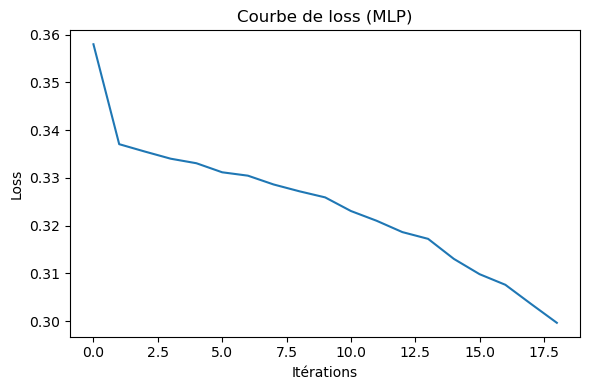

In [12]:
# Accès au modèle interne
mlp_clf = best_mlp.named_steps["clf"]

plt.figure(figsize=(6,4))
plt.plot(mlp_clf.loss_curve_)
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.title("Courbe de loss (MLP)")
plt.tight_layout()
plt.show()

## X Final

In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, f1_score,
    classification_report, confusion_matrix
)

RANDOM_STATE = 42

# === 1. Chargement base complète ===
X_full = pd.read_csv("data/X_final.csv")
y = pd.read_csv("data/y.csv").squeeze().astype(int)
y.name = "target"

print(f"Shape X_full: {X_full.shape} | Shape y: {y.shape}")
print("Distribution de la cible:\n", y.value_counts(normalize=True).round(3))

# Split stratifié
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_full, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train full:", X_train_f.shape, "| Test full:", X_test_f.shape)

# === 2. Colonnes numériques / catégorielles ===
num_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_full.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Nb num: {len(num_cols)} | Nb cat: {len(cat_cols)}")

# === 3. Préprocesseur pour toutes les variables ===
preproc_full = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

Shape X_full: (98053, 54) | Shape y: (98053,)
Distribution de la cible:
 target
0    0.887
1    0.113
Name: proportion, dtype: float64
Train full: (78442, 54) | Test full: (19611, 54)
Nb num: 51 | Nb cat: 3


In [18]:
# === 3. Préprocesseur pour toutes les variables ===
preproc_full = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ],
    remainder="drop"
)

# === 4. MLP sur toutes les variables ===
mlp_full = Pipeline([
    ("preproc", preproc_full),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation="relu",
        alpha=1e-4,
        batch_size=512,
        learning_rate_init=1e-3,
        max_iter=120,
        early_stopping=True,
        random_state=RANDOM_STATE
    ))
])

# === 5. Validation croisée PR-AUC / ROC-AUC ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}

scores_full = cross_validate(
    mlp_full,
    X_train_f, y_train_f,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

In [19]:
print(f"MLP full | CV PR-AUC  : {scores_full['test_pr_auc'].mean():.3f} ± {scores_full['test_pr_auc'].std():.3f}")
print(f"MLP full | CV ROC-AUC : {scores_full['test_roc_auc'].mean():.3f} ± {scores_full['test_roc_auc'].std():.3f}")

# === 6. Entraînement final + test ===
mlp_full.fit(X_train_f, y_train_f)
proba_full = mlp_full.predict_proba(X_test_f)[:, 1]

print(f"\nTest PR-AUC  (MLP full): {average_precision_score(y_test_f, proba_full):.3f}")
print(f"Test ROC-AUC (MLP full): {roc_auc_score(y_test_f, proba_full):.3f}")


MLP full | CV PR-AUC  : 0.198 ± 0.007
MLP full | CV ROC-AUC : 0.632 ± 0.006

Test PR-AUC  (MLP full): 0.191
Test ROC-AUC (MLP full): 0.624


In [20]:
# === 7. Seuil optimal (max F1) ===
precision, recall, thresholds = precision_recall_curve(y_test_f, proba_full)
f1 = 2 * precision * recall / (precision + recall + 1e-12)
idx = np.nanargmax(f1)
thr_full = thresholds[idx-1] if 0 < idx < len(thresholds) else 0.5

y_pred_full = (proba_full >= thr_full).astype(int)

print(f"\nSeuil choisi (max F1, MLP full) : {thr_full:.3f} | F1 = {f1[idx]:.3f}\n")
print("Classification report (MLP full) :")
print(classification_report(y_test_f, y_pred_full, digits=3))

cm_full = confusion_matrix(y_test_f, y_pred_full)
print("Confusion matrix (MLP full):\n", cm_full)


Seuil choisi (max F1, MLP full) : 0.137 | F1 = 0.254

Classification report (MLP full) :
              precision    recall  f1-score   support

           0      0.911     0.765     0.832     17398
           1      0.183     0.415     0.254      2213

    accuracy                          0.725     19611
   macro avg      0.547     0.590     0.543     19611
weighted avg      0.829     0.725     0.767     19611

Confusion matrix (MLP full):
 [[13305  4093]
 [ 1294   919]]


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform

pipe_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        activation="relu",
        early_stopping=True,
        max_iter=150,
        random_state=42))
])

param_dist = {
    "clf__hidden_layer_sizes": [(64,), (128,), (128,64), (256,128,64)],
    "clf__alpha": loguniform(1e-5, 1e-2),
    "clf__batch_size": [256, 512, 1024],
    "clf__learning_rate_init": loguniform(1e-4, 5e-3),
}

search = RandomizedSearchCV(
    pipe_mlp,
    param_distributions=param_dist,
    n_iter=20,
    scoring="average_precision",
    cv=5,
    n_jobs=-1,
    random_state=42,
)

search.fit(X_train, y_train)
print("Best PR-AUC (CV):", search.best_score_)
print("Best params:", search.best_params_)


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

ros = RandomOverSampler(random_state=42)

mlp_bal = ImbPipeline([
    ("ros", ros),
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128,64),
        activation="relu",
        early_stopping=True,
        max_iter=150,
        random_state=42))
])


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_mlp, X_test, y_test,
    n_repeats=10,
    scoring="average_precision",
    random_state=42,
    n_jobs=-1
)

imp = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)
print(imp.head(15))
